## **LAB 2**

## _TASK 1_

CodeCarbon library and necessary imports for the lab.

**For MacOS**

In [47]:
%pip install -q tensorflow codecarbon

Note: you may need to restart the kernel to use updated packages.


In [48]:
%pip install -q tensorflow-macos tensorflow-metal codecarbon

ERROR: Could not find a version that satisfies the requirement tensorflow-macos (from versions: none)
ERROR: No matching distribution found for tensorflow-macos
Note: you may need to restart the kernel to use updated packages.


**For COLAB**

In [49]:
%pip install -q codecarbon

Note: you may need to restart the kernel to use updated packages.


In [50]:
!pip install codecarbon

In [67]:
import os
import random
import time
from pathlib import Path
from zipfile import ZipFile

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from codecarbon import EmissionsTracker
from sklearn.metrics import classification_report, confusion_matrix

# Montar Google Drive si estamos en Colab
try:
    import google.colab  # type: ignore
    from google.colab import drive  # type: ignore
    drive.mount("/content/drive")
    print("Google Drive mounted")
except ImportError:
    print("Not running in Colab (no google.colab)")

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

print("TensorFlow version:", tf.__version__)
print("Physical devices:", tf.config.list_physical_devices())

possible_paths = [
    Path("/content/data"),
    Path("/content/drive/MyDrive/data"),
    Path("/content/drive/MyDrive/Colab Notebooks/Machine Learning for Sound and Music/data"),
    Path.cwd() / "data",
    Path.cwd().parent / "data",
]

data_dir = None
for p in possible_paths:
    if p.exists():
        data_dir = p
        break

# Si no hay carpeta data, intentamos con data.zip
if data_dir is None:
    zip_candidates = [
        Path("/content/data.zip"),
        Path("/content/drive/MyDrive/data.zip"),
        Path("/content/drive/MyDrive/Colab Notebooks/Machine Learning for Sound and Music/data.zip"),
    ]
    for z in zip_candidates:
        if z.exists():
            print(f"Found zip at {z}")
            # Extraemos en la CARPETA PADRE, porque el zip ya contiene una carpeta "data/"
            with ZipFile(z, "r") as zf:
                zf.extractall(z.parent)
            data_dir = z.parent / "data"
            break

if data_dir is None:
    raise FileNotFoundError("No se encuentra la carpeta 'data' ni un archivo 'data.zip' en rutas conocidas")

# Caso especial macOS: data/data/... (carpeta interna 'data')
if not (data_dir / "images_original").exists():
    inner_data = data_dir / "data"
    if inner_data.exists() and (inner_data / "images_original").exists():
        print("Detected nested 'data/data', using inner data folder")
        data_dir = inner_data

images_dir = data_dir / "images_original"
genres_dir = data_dir / "genres_original"

print("USING DATA DIR:", data_dir)
print("Images dir exists:", images_dir.exists(), images_dir)
print("Genres dir exists:", genres_dir.exists(), genres_dir)

Not running in Colab (no google.colab)
TensorFlow version: 2.20.0
Physical devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
USING DATA DIR: /Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Machine Learning for Music/Labs/data
Images dir exists: True /Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Machine Learning for Music/Labs/data/images_original
Genres dir exists: True /Users/meco/Library/CloudStorage/OneDrive-Personal/Educación/UPF/Cursos/Machine Learning for Music/Labs/data/genres_original


**Construction of the spectograms dataset**

* Dataframe with 2 columns made from images_original.
* Split of 80-20 for training and test. Also within training set, a 20% for validation.

In [52]:
image_filepaths = []
image_labels = []

for genre_name in sorted(os.listdir(images_dir)):
    genre_path = images_dir / genre_name
    if not genre_path.is_dir():
        continue
    for fname in os.listdir(genre_path):
        if fname.lower().endswith((".png", ".jpg", ".jpeg")):
            image_filepaths.append(str(genre_path / fname))
            image_labels.append(genre_name)

df = pd.DataFrame({"filepath": image_filepaths, "label": image_labels})
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
print(df.head())
print("Total images:", len(df))
print(df["label"].value_counts())

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df["label"],
    random_state=42
)

train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["label"],
    random_state=42
)

print("Train size:", len(train_df))
print("Val size:", len(val_df))
print("Test size:", len(test_df))

                                            filepath    label
0  /Users/meco/Library/CloudStorage/OneDrive-Pers...   hiphop
1  /Users/meco/Library/CloudStorage/OneDrive-Pers...      pop
2  /Users/meco/Library/CloudStorage/OneDrive-Pers...  country
3  /Users/meco/Library/CloudStorage/OneDrive-Pers...    disco
4  /Users/meco/Library/CloudStorage/OneDrive-Pers...      pop
Total images: 999
label
hiphop       100
pop          100
country      100
disco        100
reggae       100
metal        100
rock         100
blues        100
classical    100
jazz          99
Name: count, dtype: int64
Train size: 639
Val size: 160
Test size: 200


**Image generator for CNN**

* Usage of ImageDataGenerator from Keras to load images and rescale them.
* Use of images 128x128, RGB and a batch of 32.
* Use of internal split for normalization and batching.

In [53]:
'''
img_size_cnn = (128, 128)
batch_size = 32

train_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen_cnn = train_datagen_cnn.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_cnn,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_gen_cnn = val_datagen_cnn.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_cnn,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

test_gen_cnn = test_datagen_cnn.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_cnn,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

class_indices = train_gen_cnn.class_indices
num_classes = len(class_indices)
print("Classes:", class_indices)
print("Num classes:", num_classes)
'''

'\nimg_size_cnn = (128, 128)\nbatch_size = 32\n\ntrain_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)\nval_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)\ntest_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)\n\ntrain_gen_cnn = train_datagen_cnn.flow_from_dataframe(\n    train_df,\n    x_col="filepath",\n    y_col="label",\n    target_size=img_size_cnn,\n    class_mode="categorical",\n    batch_size=batch_size,\n    shuffle=True\n)\n\nval_gen_cnn = val_datagen_cnn.flow_from_dataframe(\n    val_df,\n    x_col="filepath",\n    y_col="label",\n    target_size=img_size_cnn,\n    class_mode="categorical",\n    batch_size=batch_size,\n    shuffle=True\n)\n\ntest_gen_cnn = test_datagen_cnn.flow_from_dataframe(\n    test_df,\n    x_col="filepath",\n    y_col="label",\n    target_size=img_size_cnn,\n    class_mode="categorical",\n    batch_size=batch_size,\n    shuffle=False\n)\n\nclass_indices = train_gen_cnn.class_indices\nnum_classes = len(class_indices)\nprint("Classes:",

In [54]:
img_size_cnn = (128, 128)
batch_size = 32

train_datagen_cnn = ImageDataGenerator(
    rescale=1.0 / 255.0,
    width_shift_range=0.05,
    height_shift_range=0.05
)

val_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen_cnn = ImageDataGenerator(rescale=1.0 / 255.0)

train_gen_cnn = train_datagen_cnn.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_cnn,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_gen_cnn = val_datagen_cnn.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_cnn,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

test_gen_cnn = test_datagen_cnn.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_cnn,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

class_indices = train_gen_cnn.class_indices
num_classes = len(class_indices)
print("Classes:", class_indices)
print("Num classes:", num_classes)

Found 639 validated image filenames belonging to 10 classes.
Found 160 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Classes: {'blues': 0, 'classical': 1, 'country': 2, 'disco': 3, 'hiphop': 4, 'jazz': 5, 'metal': 6, 'pop': 7, 'reggae': 8, 'rock': 9}
Num classes: 10


**CNN model trained from 0**

* Compact CNN architecture based from convolutional blocks with Conv2D, MaxPooling2D and Dropout.
* Model ends with a dense layer with Softmax activation equally big as the amount of genres.
* Use of categorical crossentropy as loss functión and Adam optimizer.

In [55]:
def build_cnn_scratch(input_shape, num_classes, base_filters=32, n_blocks=3, dense_units=128, dropout_rate=0.4, learning_rate=1e-3):
    model = models.Sequential()
    model.add(layers.Input(shape=input_shape))
    filters = base_filters
    for _ in range(n_blocks):
        model.add(layers.Conv2D(filters, (3, 3), activation="relu", padding="same"))
        model.add(layers.Conv2D(filters, (3, 3), activation="relu", padding="same"))
        model.add(layers.MaxPooling2D((2, 2)))
        model.add(layers.Dropout(dropout_rate))
        filters *= 2
    model.add(layers.Flatten())
    model.add(layers.Dense(dense_units, activation="relu"))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.Dense(num_classes, activation="softmax"))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    return model

input_shape_cnn = (img_size_cnn[0], img_size_cnn[1], 3)
cnn_model = build_cnn_scratch(input_shape_cnn, num_classes)
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 128, 128, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 32, 32, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,482,730 (17.10 MB)

 Trainable params: 4,482,730 (17.10 MB)

 Non-trainable params: 0 (0.00 B)

**CNN Training from 0 with computational effort measured**

* Epochs are set
* Use of model.fit with EmissionsTracker by CodeCarbon. Also using time.time. We get:
    * Average CO2 emissions
    * Energy consumed
    * Experiment duration

In [56]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

epochs_cnn = 40

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5
)

tracker_cnn = EmissionsTracker(project_name="lab2_cnn_scratch")
tracker_cnn.start()
start_time_cnn = time.time()

history_cnn = cnn_model.fit(
    train_gen_cnn,
    epochs=epochs_cnn,
    validation_data=val_gen_cnn,
    callbacks=[early_stop, reduce_lr]
)

end_time_cnn = time.time()
emissions_cnn = tracker_cnn.stop()

elapsed_cnn = end_time_cnn - start_time_cnn
print("Elapsed time (s):", elapsed_cnn)
print("Estimated CO2 emissions (kg):", emissions_cnn)

[codecarbon WARNING @ 13:28:01] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:28:01] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 13:28:01] [setup] RAM Tracking...
[codecarbon INFO @ 13:28:01] [setup] CPU Tracking...
[codecarbon WARNING @ 13:28:01] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 13:28:01] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon WARNING @ 13:28:01] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:28:01] [setup] GPU Tracking...
[codecarbon INFO @ 13:28:01] No GPU found.
[codecarbon INFO @ 13:28:01] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global const

Epoch 1/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 380ms/step - accuracy: 0.0892 - loss: 2.3428 - val_accuracy: 0.1375 - val_loss: 2.3023 - learning_rate: 0.0010
Epoch 2/40
17/20 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.1174 - loss: 2.3022

[codecarbon INFO @ 13:28:20] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:28:20] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:28:20] Energy consumed for All CPU : 0.000021 kWh
[codecarbon INFO @ 13:28:20] 0.000046 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.1205 - loss: 2.3020 - val_accuracy: 0.1437 - val_loss: 2.2984 - learning_rate: 0.0010
Epoch 3/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 365ms/step - accuracy: 0.1565 - loss: 2.2460 - val_accuracy: 0.2125 - val_loss: 2.1652 - learning_rate: 0.0010
Epoch 4/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step - accuracy: 0.1846 - loss: 2.1811

[codecarbon INFO @ 13:28:35] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:28:35] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:28:35] Energy consumed for All CPU : 0.000042 kWh
[codecarbon INFO @ 13:28:35] 0.000092 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.1815 - loss: 2.2182 - val_accuracy: 0.1688 - val_loss: 2.2801 - learning_rate: 0.0010
Epoch 5/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - accuracy: 0.1268 - loss: 2.2919 - val_accuracy: 0.1625 - val_loss: 2.2818 - learning_rate: 0.0010
Epoch 6/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step - accuracy: 0.1883 - loss: 2.2263

[codecarbon INFO @ 13:28:50] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:28:50] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:28:50] Energy consumed for All CPU : 0.000063 kWh
[codecarbon INFO @ 13:28:50] 0.000137 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 363ms/step - accuracy: 0.1941 - loss: 2.1814 - val_accuracy: 0.2625 - val_loss: 2.1322 - learning_rate: 0.0010
Epoch 7/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 378ms/step - accuracy: 0.1862 - loss: 2.1174 - val_accuracy: 0.2375 - val_loss: 2.0617 - learning_rate: 0.0010
Epoch 8/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.2332 - loss: 2.0713 - val_accuracy: 0.2688 - val_loss: 2.0450 - learning_rate: 0.0010
Epoch 9/40


[codecarbon INFO @ 13:29:05] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:29:05] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:29:05] Energy consumed for All CPU : 0.000083 kWh
[codecarbon INFO @ 13:29:05] 0.000183 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.2394 - loss: 2.0478 - val_accuracy: 0.2812 - val_loss: 1.9983 - learning_rate: 0.0010
Epoch 10/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.2801 - loss: 2.0137 - val_accuracy: 0.2438 - val_loss: 2.0104 - learning_rate: 0.0010
Epoch 11/40
 2/20 ━━━━━━━━━━━━━━━━━━━━ 6s 362ms/step - accuracy: 0.2422 - loss: 2.0523

[codecarbon INFO @ 13:29:20] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:29:20] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:29:20] Energy consumed for All CPU : 0.000104 kWh
[codecarbon INFO @ 13:29:20] 0.000229 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.2676 - loss: 1.9744 - val_accuracy: 0.3500 - val_loss: 1.9740 - learning_rate: 0.0010
Epoch 12/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.2864 - loss: 1.9590 - val_accuracy: 0.3063 - val_loss: 1.9298 - learning_rate: 0.0010
Epoch 13/40
 4/20 ━━━━━━━━━━━━━━━━━━━━ 5s 321ms/step - accuracy: 0.2923 - loss: 2.0141

[codecarbon INFO @ 13:29:35] Energy consumed for RAM : 0.000150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:29:35] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:29:35] Energy consumed for All CPU : 0.000125 kWh
[codecarbon INFO @ 13:29:35] 0.000275 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.3192 - loss: 1.8918 - val_accuracy: 0.3313 - val_loss: 1.8748 - learning_rate: 0.0010
Epoch 14/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.3349 - loss: 1.9090 - val_accuracy: 0.3562 - val_loss: 1.9317 - learning_rate: 0.0010
Epoch 15/40
 7/20 ━━━━━━━━━━━━━━━━━━━━ 4s 329ms/step - accuracy: 0.3980 - loss: 1.7627

[codecarbon INFO @ 13:29:50] Energy consumed for RAM : 0.000175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:29:50] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:29:50] Energy consumed for All CPU : 0.000146 kWh
[codecarbon INFO @ 13:29:50] 0.000321 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.3505 - loss: 1.8335 - val_accuracy: 0.4000 - val_loss: 1.7761 - learning_rate: 0.0010
Epoch 16/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.3803 - loss: 1.7966 - val_accuracy: 0.3187 - val_loss: 1.8852 - learning_rate: 0.0010
Epoch 17/40
 9/20 ━━━━━━━━━━━━━━━━━━━━ 3s 323ms/step - accuracy: 0.3854 - loss: 1.7492

[codecarbon INFO @ 13:30:05] Energy consumed for RAM : 0.000200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:30:05] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:30:05] Energy consumed for All CPU : 0.000167 kWh
[codecarbon INFO @ 13:30:05] 0.000367 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:30:05] 0.000531 g.CO2eq/s mean an estimation of 16.757684598643127 kg.CO2eq/year


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.3646 - loss: 1.7494 - val_accuracy: 0.3688 - val_loss: 1.7446 - learning_rate: 0.0010
Epoch 18/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 347ms/step - accuracy: 0.3881 - loss: 1.7815 - val_accuracy: 0.3875 - val_loss: 1.7838 - learning_rate: 0.0010
Epoch 19/40
12/20 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.3775 - loss: 1.7367

[codecarbon INFO @ 13:30:20] Energy consumed for RAM : 0.000225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:30:20] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:30:20] Energy consumed for All CPU : 0.000187 kWh
[codecarbon INFO @ 13:30:20] 0.000412 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.3662 - loss: 1.7625 - val_accuracy: 0.3438 - val_loss: 1.7516 - learning_rate: 0.0010
Epoch 20/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 353ms/step - accuracy: 0.3991 - loss: 1.6979 - val_accuracy: 0.3688 - val_loss: 1.6520 - learning_rate: 0.0010
Epoch 21/40
14/20 ━━━━━━━━━━━━━━━━━━━━ 1s 324ms/step - accuracy: 0.4286 - loss: 1.6344

[codecarbon INFO @ 13:30:35] Energy consumed for RAM : 0.000250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:30:35] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:30:35] Energy consumed for All CPU : 0.000208 kWh
[codecarbon INFO @ 13:30:35] 0.000458 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 356ms/step - accuracy: 0.4163 - loss: 1.6780 - val_accuracy: 0.3000 - val_loss: 1.7758 - learning_rate: 0.0010
Epoch 22/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.3756 - loss: 1.7001 - val_accuracy: 0.4000 - val_loss: 1.6318 - learning_rate: 0.0010
Epoch 23/40
16/20 ━━━━━━━━━━━━━━━━━━━━ 1s 336ms/step - accuracy: 0.3847 - loss: 1.6971

[codecarbon INFO @ 13:30:50] Energy consumed for RAM : 0.000275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:30:50] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:30:50] Energy consumed for All CPU : 0.000229 kWh
[codecarbon INFO @ 13:30:50] 0.000504 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - accuracy: 0.3928 - loss: 1.7023 - val_accuracy: 0.4000 - val_loss: 1.6996 - learning_rate: 0.0010
Epoch 24/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.3897 - loss: 1.6411 - val_accuracy: 0.4000 - val_loss: 1.6339 - learning_rate: 0.0010
Epoch 25/40
18/20 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step - accuracy: 0.4257 - loss: 1.6246

[codecarbon INFO @ 13:31:05] Energy consumed for RAM : 0.000300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:31:05] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:31:05] Energy consumed for All CPU : 0.000250 kWh
[codecarbon INFO @ 13:31:05] 0.000550 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.4382 - loss: 1.5812 - val_accuracy: 0.3938 - val_loss: 1.6364 - learning_rate: 0.0010
Epoch 26/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.4491 - loss: 1.5218 - val_accuracy: 0.4125 - val_loss: 1.6256 - learning_rate: 5.0000e-04
Epoch 27/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.4679 - loss: 1.5496 - val_accuracy: 0.4437 - val_loss: 1.6022 - learning_rate: 5.0000e-04
Epoch 28/40


[codecarbon INFO @ 13:31:20] Energy consumed for RAM : 0.000325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:31:20] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:31:20] Energy consumed for All CPU : 0.000271 kWh
[codecarbon INFO @ 13:31:20] 0.000596 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.4695 - loss: 1.4461 - val_accuracy: 0.4375 - val_loss: 1.5608 - learning_rate: 5.0000e-04
Epoch 29/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 355ms/step - accuracy: 0.4804 - loss: 1.4559 - val_accuracy: 0.4625 - val_loss: 1.5728 - learning_rate: 5.0000e-04
Epoch 30/40
 2/20 ━━━━━━━━━━━━━━━━━━━━ 5s 325ms/step - accuracy: 0.5312 - loss: 1.3866

[codecarbon INFO @ 13:31:35] Energy consumed for RAM : 0.000350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:31:35] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:31:35] Energy consumed for All CPU : 0.000292 kWh
[codecarbon INFO @ 13:31:35] 0.000642 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.4945 - loss: 1.3820 - val_accuracy: 0.4563 - val_loss: 1.5659 - learning_rate: 5.0000e-04
Epoch 31/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 361ms/step - accuracy: 0.5149 - loss: 1.3608 - val_accuracy: 0.4125 - val_loss: 1.6448 - learning_rate: 5.0000e-04
Epoch 32/40
 4/20 ━━━━━━━━━━━━━━━━━━━━ 5s 335ms/step - accuracy: 0.5422 - loss: 1.3149

[codecarbon INFO @ 13:31:50] Energy consumed for RAM : 0.000375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:31:50] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:31:50] Energy consumed for All CPU : 0.000312 kWh
[codecarbon INFO @ 13:31:50] 0.000687 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.5274 - loss: 1.3253 - val_accuracy: 0.4250 - val_loss: 1.5829 - learning_rate: 2.5000e-04
Epoch 33/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.5243 - loss: 1.3071 - val_accuracy: 0.4938 - val_loss: 1.5486 - learning_rate: 2.5000e-04
Epoch 34/40
 6/20 ━━━━━━━━━━━━━━━━━━━━ 4s 334ms/step - accuracy: 0.6199 - loss: 1.1725

[codecarbon INFO @ 13:32:05] Energy consumed for RAM : 0.000400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:32:05] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:32:05] Energy consumed for All CPU : 0.000333 kWh
[codecarbon INFO @ 13:32:05] 0.000733 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:32:05] 0.000532 g.CO2eq/s mean an estimation of 16.76591348289483 kg.CO2eq/year


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.5571 - loss: 1.2813 - val_accuracy: 0.4812 - val_loss: 1.5375 - learning_rate: 2.5000e-04
Epoch 35/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 354ms/step - accuracy: 0.5634 - loss: 1.2214 - val_accuracy: 0.5063 - val_loss: 1.5499 - learning_rate: 2.5000e-04
Epoch 36/40
 9/20 ━━━━━━━━━━━━━━━━━━━━ 3s 322ms/step - accuracy: 0.5721 - loss: 1.1589

[codecarbon INFO @ 13:32:20] Energy consumed for RAM : 0.000425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:32:20] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:32:20] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 13:32:20] 0.000779 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 351ms/step - accuracy: 0.5634 - loss: 1.2330 - val_accuracy: 0.4938 - val_loss: 1.5296 - learning_rate: 2.5000e-04
Epoch 37/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 348ms/step - accuracy: 0.5587 - loss: 1.2375 - val_accuracy: 0.4313 - val_loss: 1.5626 - learning_rate: 2.5000e-04
Epoch 38/40
12/20 ━━━━━━━━━━━━━━━━━━━━ 2s 323ms/step - accuracy: 0.6045 - loss: 1.1765

[codecarbon INFO @ 13:32:35] Energy consumed for RAM : 0.000450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:32:35] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:32:35] Energy consumed for All CPU : 0.000375 kWh
[codecarbon INFO @ 13:32:35] 0.000825 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.5649 - loss: 1.2337 - val_accuracy: 0.5188 - val_loss: 1.5248 - learning_rate: 2.5000e-04
Epoch 39/40
20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 357ms/step - accuracy: 0.5493 - loss: 1.2524 - val_accuracy: 0.4750 - val_loss: 1.5185 - learning_rate: 2.5000e-04
Epoch 40/40
14/20 ━━━━━━━━━━━━━━━━━━━━ 1s 333ms/step - accuracy: 0.5607 - loss: 1.2036

[codecarbon INFO @ 13:32:50] Energy consumed for RAM : 0.000475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:32:50] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:32:50] Energy consumed for All CPU : 0.000396 kWh
[codecarbon INFO @ 13:32:50] 0.000871 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - accuracy: 0.5665 - loss: 1.1597 - val_accuracy: 0.4875 - val_loss: 1.5668 - learning_rate: 2.5000e-04


[codecarbon INFO @ 13:32:52] Energy consumed for RAM : 0.000479 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:32:52] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 5.0 W
[codecarbon INFO @ 13:32:52] Energy consumed for All CPU : 0.000399 kWh
[codecarbon INFO @ 13:32:52] 0.000878 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:32:52] The CSV format has changed, backing up old emission file.


Elapsed time (s): 287.5660049915314
Estimated CO2 emissions (kg): 0.00015285272201852164


**Measurements for accuracy with curves**

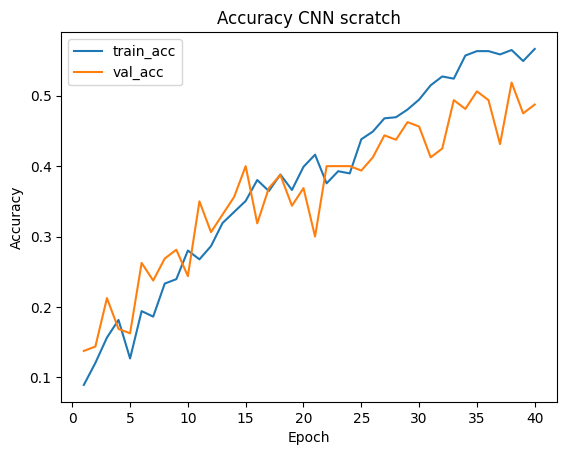

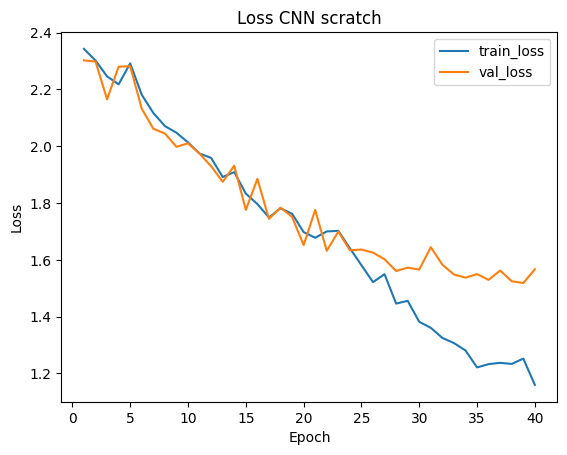

In [57]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs_range, acc, label="train_acc")
    plt.plot(epochs_range, val_acc, label="val_acc")
    plt.title(f"Accuracy {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs_range, loss, label="train_loss")
    plt.plot(epochs_range, val_loss, label="val_loss")
    plt.title(f"Loss {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history_cnn, title="CNN scratch")

**Evaluation of de CNN model with the test**

In [58]:
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(test_gen_cnn)
print("Test loss (CNN scratch):", test_loss_cnn)
print("Test accuracy (CNN scratch):", test_acc_cnn)

y_prob_cnn = cnn_model.predict(test_gen_cnn)
y_pred_cnn = np.argmax(y_prob_cnn, axis=1)
y_true_cnn = test_gen_cnn.classes
class_indices = test_gen_cnn.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

print(classification_report(y_true_cnn, y_pred_cnn, target_names=[idx_to_class[i] for i in range(len(idx_to_class))]))
print(confusion_matrix(y_true_cnn, y_pred_cnn))

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - accuracy: 0.5500 - loss: 1.4112
Test loss (CNN scratch): 1.4111741781234741
Test accuracy (CNN scratch): 0.550000011920929
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step
              precision    recall  f1-score   support

       blues       0.61      0.55      0.58        20
   classical       0.73      0.80      0.76        20
     country       0.46      0.30      0.36        20
       disco       0.42      0.65      0.51        20
      hiphop       0.57      0.65      0.60        20
        jazz       0.65      0.65      0.65        20
       metal       0.76      0.80      0.78        20
         pop       0.53      0.40      0.46        20
      reggae       0.46      0.55      0.50        20
        rock       0.23      0.15      0.18        20

    accuracy                           0.55       200
   macro avg       0.54      0.55      0.54       200
weighted avg       0.54      0.55      0.54       200

[[11  0  1  3  0  0  1  0  3  1]
 [ 1 16

## _TASK 2_

**We generate the data for the pretrained model (TASK 2)**

In [59]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

img_size_vgg = (224, 224)

train_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen_vgg = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen_vgg = train_datagen_vgg.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_vgg,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_gen_vgg = val_datagen_vgg.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_vgg,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

test_gen_vgg = test_datagen_vgg.flow_from_dataframe(
    test_df,
    x_col="filepath",
    y_col="label",
    target_size=img_size_vgg,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

Found 639 validated image filenames belonging to 10 classes.
Found 160 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.


**Pretrained model with VGG16 and new classification head**

In [60]:
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size_vgg[0], img_size_vgg[1], 3)
)

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

vgg_model = models.Model(inputs=base_model.input, outputs=output)

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

vgg_model.summary()

Model: "functional_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,848,586 (56.64 MB)

 Trainable params: 133,898 (523.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

**Training of the models head and measurement of impact (CO2)**


In [61]:
epochs_vgg_head = 10

tracker_vgg_head = EmissionsTracker(project_name="lab2_vgg_head")
tracker_vgg_head.start()
start_time_vgg_head = time.time()

history_vgg_head = vgg_model.fit(
    train_gen_vgg,
    epochs=epochs_vgg_head,
    validation_data=val_gen_vgg
)

end_time_vgg_head = time.time()
emissions_vgg_head = tracker_vgg_head.stop()

elapsed_vgg_head = end_time_vgg_head - start_time_vgg_head
print("Elapsed time head (s):", elapsed_vgg_head)
print("Estimated CO2 emissions head (kg):", emissions_vgg_head)

[codecarbon WARNING @ 13:32:54] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:32:54] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 13:32:54] [setup] RAM Tracking...
[codecarbon INFO @ 13:32:54] [setup] CPU Tracking...
[codecarbon WARNING @ 13:32:54] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 13:32:54] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon WARNING @ 13:32:54] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:32:54] [setup] GPU Tracking...
[codecarbon INFO @ 13:32:54] No GPU found.
[codecarbon INFO @ 13:32:54] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global const

Epoch 1/10
 7/20 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.1421 - loss: 9.2815

[codecarbon INFO @ 13:33:10] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:33:10] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:33:10] Energy consumed for All CPU : 0.000021 kWh
[codecarbon INFO @ 13:33:10] 0.000046 kWh of electricity and 0.000000 L of water were used since the beginning.


15/20 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.1426 - loss: 8.2066 

[codecarbon INFO @ 13:33:25] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:33:25] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:33:26] Energy consumed for All CPU : 0.000042 kWh
[codecarbon INFO @ 13:33:26] 0.000092 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1480 - loss: 7.7086

[codecarbon INFO @ 13:33:40] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:33:40] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:33:41] Energy consumed for All CPU : 0.000062 kWh
[codecarbon INFO @ 13:33:41] 0.000137 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 50s 3s/step - accuracy: 0.1768 - loss: 5.9448 - val_accuracy: 0.3750 - val_loss: 2.0804
Epoch 2/10
 4/20 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.2552 - loss: 3.7693

[codecarbon INFO @ 13:33:55] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:33:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:33:56] Energy consumed for All CPU : 0.000083 kWh
[codecarbon INFO @ 13:33:56] 0.000183 kWh of electricity and 0.000000 L of water were used since the beginning.


11/20 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.2427 - loss: 3.6289

[codecarbon INFO @ 13:34:10] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:34:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:34:11] Energy consumed for All CPU : 0.000104 kWh
[codecarbon INFO @ 13:34:11] 0.000228 kWh of electricity and 0.000000 L of water were used since the beginning.


19/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2597 - loss: 3.3710

[codecarbon INFO @ 13:34:25] Energy consumed for RAM : 0.000149 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:34:25] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:34:25] Energy consumed for All CPU : 0.000125 kWh
[codecarbon INFO @ 13:34:25] 0.000274 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 49s 2s/step - accuracy: 0.2942 - loss: 2.8051 - val_accuracy: 0.4812 - val_loss: 1.5527
Epoch 3/10
 2/20 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.3828 - loss: 1.8519

[codecarbon INFO @ 13:34:41] Energy consumed for RAM : 0.000174 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:34:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:34:41] Energy consumed for All CPU : 0.000146 kWh
[codecarbon INFO @ 13:34:41] 0.000320 kWh of electricity and 0.000000 L of water were used since the beginning.


10/20 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.3880 - loss: 1.8323

[codecarbon INFO @ 13:34:56] Energy consumed for RAM : 0.000199 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:34:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:34:56] Energy consumed for All CPU : 0.000166 kWh
[codecarbon INFO @ 13:34:56] 0.000366 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:34:56] 0.000530 g.CO2eq/s mean an estimation of 16.706861026092085 kg.CO2eq/year


19/20 ━━━━━━━━━━━━━━━━━━━━ 1s 2s/step - accuracy: 0.4020 - loss: 1.7976

[codecarbon INFO @ 13:35:11] Energy consumed for RAM : 0.000224 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:35:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:35:11] Energy consumed for All CPU : 0.000187 kWh
[codecarbon INFO @ 13:35:11] 0.000411 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4085 - loss: 1.7474 - val_accuracy: 0.4875 - val_loss: 1.4962
Epoch 4/10
 2/20 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.5747 - loss: 1.4729

[codecarbon INFO @ 13:35:26] Energy consumed for RAM : 0.000249 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:35:26] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:35:26] Energy consumed for All CPU : 0.000208 kWh
[codecarbon INFO @ 13:35:26] 0.000457 kWh of electricity and 0.000000 L of water were used since the beginning.


10/20 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.5010 - loss: 1.5398

[codecarbon INFO @ 13:35:41] Energy consumed for RAM : 0.000274 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:35:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:35:41] Energy consumed for All CPU : 0.000229 kWh
[codecarbon INFO @ 13:35:41] 0.000503 kWh of electricity and 0.000000 L of water were used since the beginning.


18/20 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step - accuracy: 0.4835 - loss: 1.5559

[codecarbon INFO @ 13:35:56] Energy consumed for RAM : 0.000299 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:35:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:35:56] Energy consumed for All CPU : 0.000250 kWh
[codecarbon INFO @ 13:35:56] 0.000549 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.4726 - loss: 1.5233 - val_accuracy: 0.5125 - val_loss: 1.4544
Epoch 5/10
 1/20 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.4062 - loss: 1.4753

[codecarbon INFO @ 13:36:11] Energy consumed for RAM : 0.000324 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:36:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:36:11] Energy consumed for All CPU : 0.000270 kWh
[codecarbon INFO @ 13:36:11] 0.000595 kWh of electricity and 0.000000 L of water were used since the beginning.


 9/20 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 0.4556 - loss: 1.4574

[codecarbon INFO @ 13:36:26] Energy consumed for RAM : 0.000349 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:36:26] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:36:26] Energy consumed for All CPU : 0.000291 kWh
[codecarbon INFO @ 13:36:26] 0.000641 kWh of electricity and 0.000000 L of water were used since the beginning.


17/20 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.4738 - loss: 1.4402

[codecarbon INFO @ 13:36:41] Energy consumed for RAM : 0.000374 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:36:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:36:41] Energy consumed for All CPU : 0.000312 kWh
[codecarbon INFO @ 13:36:41] 0.000686 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step - accuracy: 0.5117 - loss: 1.4069 - val_accuracy: 0.5437 - val_loss: 1.3947
Epoch 6/10


[codecarbon INFO @ 13:36:56] Energy consumed for RAM : 0.000399 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:36:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:36:56] Energy consumed for All CPU : 0.000333 kWh
[codecarbon INFO @ 13:36:56] 0.000732 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:36:56] 0.000531 g.CO2eq/s mean an estimation of 16.754797612223275 kg.CO2eq/year


 8/20 ━━━━━━━━━━━━━━━━━━━━ 22s 2s/step - accuracy: 0.5123 - loss: 1.3204

[codecarbon INFO @ 13:37:11] Energy consumed for RAM : 0.000424 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:37:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:37:11] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 13:37:11] 0.000778 kWh of electricity and 0.000000 L of water were used since the beginning.


16/20 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5128 - loss: 1.3153

[codecarbon INFO @ 13:37:26] Energy consumed for RAM : 0.000449 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:37:26] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:37:26] Energy consumed for All CPU : 0.000375 kWh
[codecarbon INFO @ 13:37:26] 0.000824 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5175 - loss: 1.3104

[codecarbon INFO @ 13:37:41] Energy consumed for RAM : 0.000474 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:37:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:37:41] Energy consumed for All CPU : 0.000395 kWh
[codecarbon INFO @ 13:37:41] 0.000869 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5399 - loss: 1.2862 - val_accuracy: 0.5813 - val_loss: 1.3156
Epoch 7/10
 8/20 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.5845 - loss: 1.3031

[codecarbon INFO @ 13:37:56] Energy consumed for RAM : 0.000499 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:37:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:37:56] Energy consumed for All CPU : 0.000416 kWh
[codecarbon INFO @ 13:37:56] 0.000915 kWh of electricity and 0.000000 L of water were used since the beginning.


16/20 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - accuracy: 0.5934 - loss: 1.2717

[codecarbon INFO @ 13:38:11] Energy consumed for RAM : 0.000524 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:38:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:38:11] Energy consumed for All CPU : 0.000437 kWh
[codecarbon INFO @ 13:38:11] 0.000961 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5943 - loss: 1.2612

[codecarbon INFO @ 13:38:26] Energy consumed for RAM : 0.000549 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:38:26] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:38:26] Energy consumed for All CPU : 0.000458 kWh
[codecarbon INFO @ 13:38:26] 0.001007 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5915 - loss: 1.2216 - val_accuracy: 0.6062 - val_loss: 1.2623
Epoch 8/10
 7/20 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5666 - loss: 1.2428

[codecarbon INFO @ 13:38:41] Energy consumed for RAM : 0.000574 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:38:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:38:41] Energy consumed for All CPU : 0.000479 kWh
[codecarbon INFO @ 13:38:41] 0.001053 kWh of electricity and 0.000000 L of water were used since the beginning.


15/20 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.5781 - loss: 1.2185 

[codecarbon INFO @ 13:38:56] Energy consumed for RAM : 0.000599 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:38:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:38:56] Energy consumed for All CPU : 0.000500 kWh
[codecarbon INFO @ 13:38:56] 0.001098 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:38:56] 0.000531 g.CO2eq/s mean an estimation of 16.75062870863129 kg.CO2eq/year


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5825 - loss: 1.2000

[codecarbon INFO @ 13:39:11] Energy consumed for RAM : 0.000624 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:39:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:39:11] Energy consumed for All CPU : 0.000520 kWh
[codecarbon INFO @ 13:39:11] 0.001144 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.5853 - loss: 1.1650 - val_accuracy: 0.6000 - val_loss: 1.2787
Epoch 9/10
 7/20 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.6140 - loss: 1.1291

[codecarbon INFO @ 13:39:26] Energy consumed for RAM : 0.000649 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:39:26] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:39:26] Energy consumed for All CPU : 0.000541 kWh
[codecarbon INFO @ 13:39:26] 0.001190 kWh of electricity and 0.000000 L of water were used since the beginning.


15/20 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6206 - loss: 1.0987 

[codecarbon INFO @ 13:39:41] Energy consumed for RAM : 0.000674 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:39:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:39:41] Energy consumed for All CPU : 0.000562 kWh
[codecarbon INFO @ 13:39:41] 0.001236 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6225 - loss: 1.0929

[codecarbon INFO @ 13:39:56] Energy consumed for RAM : 0.000699 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:39:56] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:39:56] Energy consumed for All CPU : 0.000583 kWh
[codecarbon INFO @ 13:39:56] 0.001282 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6275 - loss: 1.0767 - val_accuracy: 0.6062 - val_loss: 1.2435
Epoch 10/10
 7/20 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5945 - loss: 1.1374

[codecarbon INFO @ 13:40:11] Energy consumed for RAM : 0.000724 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:40:11] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:40:11] Energy consumed for All CPU : 0.000604 kWh
[codecarbon INFO @ 13:40:11] 0.001327 kWh of electricity and 0.000000 L of water were used since the beginning.


15/20 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.6365 - loss: 1.0914 

[codecarbon INFO @ 13:40:26] Energy consumed for RAM : 0.000749 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:40:26] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:40:26] Energy consumed for All CPU : 0.000625 kWh
[codecarbon INFO @ 13:40:26] 0.001373 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6426 - loss: 1.0832

[codecarbon INFO @ 13:40:41] Energy consumed for RAM : 0.000774 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:40:41] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:40:41] Energy consumed for All CPU : 0.000645 kWh
[codecarbon INFO @ 13:40:41] 0.001419 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.6573 - loss: 1.0455 - val_accuracy: 0.5750 - val_loss: 1.2270


[codecarbon INFO @ 13:40:43] Energy consumed for RAM : 0.000778 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:40:43] Delta energy consumed for CPU with constant : 0.000003 kWh, power : 5.0 W
[codecarbon INFO @ 13:40:43] Energy consumed for All CPU : 0.000649 kWh
[codecarbon INFO @ 13:40:43] 0.001426 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:40:43] 0.000531 g.CO2eq/s mean an estimation of 16.734985036378376 kg.CO2eq/year


Elapsed time head (s): 467.77320194244385
Estimated CO2 emissions head (kg): 0.00024825975900791405


**Fine tuning of the last convolutional block**

In [62]:
for layer in base_model.layers[-4:]:
    layer.trainable = True

vgg_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

epochs_vgg_ft = 5

tracker_vgg_ft = EmissionsTracker(project_name="lab2_vgg_finetune")
tracker_vgg_ft.start()
start_time_vgg_ft = time.time()

history_vgg_ft = vgg_model.fit(
    train_gen_vgg,
    epochs=epochs_vgg_ft,
    validation_data=val_gen_vgg
)

end_time_vgg_ft = time.time()
emissions_vgg_ft = tracker_vgg_ft.stop()

elapsed_vgg_ft = end_time_vgg_ft - start_time_vgg_ft
print("Elapsed time fine-tune (s):", elapsed_vgg_ft)
print("Estimated CO2 emissions fine-tune (kg):", emissions_vgg_ft)

[codecarbon WARNING @ 13:40:43] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon WARNING @ 13:40:43] Error while trying to count physical CPUs: [Errno 2] No such file or directory: 'lscpu'. Defaulting to 1.
[codecarbon INFO @ 13:40:43] [setup] RAM Tracking...
[codecarbon INFO @ 13:40:43] [setup] CPU Tracking...
[codecarbon WARNING @ 13:40:44] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Mac OS and ARM processor detected: Please enable PowerMetrics sudo to measure CPU

[codecarbon INFO @ 13:40:44] CPU Model on constant consumption mode: Apple M1 Pro
[codecarbon WARNING @ 13:40:44] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 13:40:44] [setup] GPU Tracking...
[codecarbon INFO @ 13:40:44] No GPU found.
[codecarbon INFO @ 13:40:44] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
                CPU Tracking Method: global const

Epoch 1/5
 6/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.5498 - loss: 1.4687

[codecarbon INFO @ 13:41:02] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:41:02] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:41:02] Energy consumed for All CPU : 0.000021 kWh
[codecarbon INFO @ 13:41:02] 0.000046 kWh of electricity and 0.000000 L of water were used since the beginning.


13/20 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5261 - loss: 1.5064

[codecarbon INFO @ 13:41:17] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:41:17] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:41:17] Energy consumed for All CPU : 0.000042 kWh
[codecarbon INFO @ 13:41:17] 0.000092 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5178 - loss: 1.5023

[codecarbon INFO @ 13:41:32] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:41:32] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:41:32] Energy consumed for All CPU : 0.000062 kWh
[codecarbon INFO @ 13:41:32] 0.000137 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5055 - loss: 1.4859 - val_accuracy: 0.5000 - val_loss: 1.4338
Epoch 2/5
 2/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.6250 - loss: 1.0262

[codecarbon INFO @ 13:41:47] Energy consumed for RAM : 0.000100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:41:47] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:41:47] Energy consumed for All CPU : 0.000083 kWh
[codecarbon INFO @ 13:41:47] 0.000183 kWh of electricity and 0.000000 L of water were used since the beginning.


 9/20 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.5799 - loss: 1.1688

[codecarbon INFO @ 13:42:02] Energy consumed for RAM : 0.000125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:42:02] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:42:02] Energy consumed for All CPU : 0.000104 kWh
[codecarbon INFO @ 13:42:02] 0.000229 kWh of electricity and 0.000000 L of water were used since the beginning.


16/20 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.5907 - loss: 1.1598 

[codecarbon INFO @ 13:42:17] Energy consumed for RAM : 0.000150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:42:17] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:42:17] Energy consumed for All CPU : 0.000125 kWh
[codecarbon INFO @ 13:42:17] 0.000275 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5947 - loss: 1.1559

[codecarbon INFO @ 13:42:32] Energy consumed for RAM : 0.000175 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:42:32] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:42:32] Energy consumed for All CPU : 0.000146 kWh
[codecarbon INFO @ 13:42:32] 0.000321 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.6135 - loss: 1.1363 - val_accuracy: 0.6250 - val_loss: 1.1684
Epoch 3/5
 5/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7074 - loss: 0.8545

[codecarbon INFO @ 13:42:47] Energy consumed for RAM : 0.000200 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:42:47] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:42:47] Energy consumed for All CPU : 0.000167 kWh
[codecarbon INFO @ 13:42:47] 0.000367 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:42:47] 0.000531 g.CO2eq/s mean an estimation of 16.757623051533184 kg.CO2eq/year


12/20 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.6959 - loss: 0.8878

[codecarbon INFO @ 13:43:02] Energy consumed for RAM : 0.000225 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:43:02] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:43:02] Energy consumed for All CPU : 0.000188 kWh
[codecarbon INFO @ 13:43:02] 0.000413 kWh of electricity and 0.000000 L of water were used since the beginning.


19/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.6956 - loss: 0.8940

[codecarbon INFO @ 13:43:17] Energy consumed for RAM : 0.000250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:43:17] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:43:17] Energy consumed for All CPU : 0.000208 kWh
[codecarbon INFO @ 13:43:17] 0.000458 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.7058 - loss: 0.8661 - val_accuracy: 0.6625 - val_loss: 1.1830
Epoch 4/5
 2/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.7266 - loss: 0.7820

[codecarbon INFO @ 13:43:32] Energy consumed for RAM : 0.000275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:43:32] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:43:32] Energy consumed for All CPU : 0.000229 kWh
[codecarbon INFO @ 13:43:32] 0.000504 kWh of electricity and 0.000000 L of water were used since the beginning.


 9/20 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.7272 - loss: 0.7433

[codecarbon INFO @ 13:43:47] Energy consumed for RAM : 0.000300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:43:47] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:43:47] Energy consumed for All CPU : 0.000250 kWh
[codecarbon INFO @ 13:43:47] 0.000550 kWh of electricity and 0.000000 L of water were used since the beginning.


16/20 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step - accuracy: 0.7341 - loss: 0.7358 

[codecarbon INFO @ 13:44:02] Energy consumed for RAM : 0.000325 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:44:02] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:44:02] Energy consumed for All CPU : 0.000271 kWh
[codecarbon INFO @ 13:44:02] 0.000596 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7381 - loss: 0.7314

[codecarbon INFO @ 13:44:17] Energy consumed for RAM : 0.000350 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:44:17] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:44:17] Energy consumed for All CPU : 0.000292 kWh
[codecarbon INFO @ 13:44:17] 0.000641 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.7574 - loss: 0.7027 - val_accuracy: 0.6562 - val_loss: 1.1705
Epoch 5/5
 5/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - accuracy: 0.7652 - loss: 0.6599

[codecarbon INFO @ 13:44:32] Energy consumed for RAM : 0.000375 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:44:32] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:44:32] Energy consumed for All CPU : 0.000312 kWh
[codecarbon INFO @ 13:44:32] 0.000687 kWh of electricity and 0.000000 L of water were used since the beginning.


12/20 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.7852 - loss: 0.6363

[codecarbon INFO @ 13:44:47] Energy consumed for RAM : 0.000400 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:44:47] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:44:47] Energy consumed for All CPU : 0.000333 kWh
[codecarbon INFO @ 13:44:47] 0.000733 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 13:44:47] 0.000531 g.CO2eq/s mean an estimation of 16.740305710683025 kg.CO2eq/year


19/20 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7963 - loss: 0.6099

[codecarbon INFO @ 13:45:02] Energy consumed for RAM : 0.000425 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:45:02] Delta energy consumed for CPU with constant : 0.000021 kWh, power : 5.0 W
[codecarbon INFO @ 13:45:02] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 13:45:02] 0.000779 kWh of electricity and 0.000000 L of water were used since the beginning.


20/20 ━━━━━━━━━━━━━━━━━━━━ 52s 3s/step - accuracy: 0.8059 - loss: 0.5849 - val_accuracy: 0.6000 - val_loss: 1.1805


[codecarbon INFO @ 13:45:12] Energy consumed for RAM : 0.000441 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 13:45:12] Delta energy consumed for CPU with constant : 0.000013 kWh, power : 5.0 W
[codecarbon INFO @ 13:45:12] Energy consumed for All CPU : 0.000368 kWh
[codecarbon INFO @ 13:45:12] 0.000808 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon WARNING @ 13:45:12] The CSV format has changed, backing up old emission file.


Elapsed time fine-tune (s): 264.8430128097534
Estimated CO2 emissions fine-tune (kg): 0.000140663760005286


**Evaluation of the pretrained model along with the testing**

In [63]:
test_loss_vgg, test_acc_vgg = vgg_model.evaluate(test_gen_vgg)
print("Test loss (VGG):", test_loss_vgg)
print("Test accuracy (VGG):", test_acc_vgg)

y_prob_vgg = vgg_model.predict(test_gen_vgg)
y_pred_vgg = np.argmax(y_prob_vgg, axis=1)
y_true_vgg = test_gen_vgg.classes
class_indices_vgg = test_gen_vgg.class_indices
idx_to_class_vgg = {v: k for k, v in class_indices_vgg.items()}

print(classification_report(y_true_vgg, y_pred_vgg, target_names=[idx_to_class_vgg[i] for i in range(len(idx_to_class_vgg))]))
print(confusion_matrix(y_true_vgg, y_pred_vgg))

7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6700 - loss: 1.0692
Test loss (VGG): 1.0691734552383423
Test accuracy (VGG): 0.6700000166893005
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
              precision    recall  f1-score   support

       blues       1.00      0.75      0.86        20
   classical       0.83      0.95      0.88        20
     country       0.65      0.55      0.59        20
       disco       0.44      0.75      0.56        20
      hiphop       0.67      0.80      0.73        20
        jazz       0.59      0.80      0.68        20
       metal       1.00      0.85      0.92        20
         pop       0.55      0.55      0.55        20
      reggae       0.70      0.35      0.47        20
        rock       0.54      0.35      0.42        20

    accuracy                           0.67       200
   macro avg       0.70      0.67      0.67       200
weighted avg       0.70      0.67      0.67       200

[[15  0  0  1  0  4  0  0  0  0]
 [ 0 19  0  0  0  1  0  

**Loading of the features CSV for comparison**

In [64]:
features_30_path = data_dir / "lab2_features_30_sec.csv"
features_3_path = data_dir / "lab2_features_3_sec.csv"

if features_30_path.exists():
    f30 = pd.read_csv(features_30_path)
    print("lab2_features_30_sec shape:", f30.shape)

if features_3_path.exists():
    f3 = pd.read_csv(features_3_path)
    print("lab2_features_3_sec shape:", f3.shape)

lab2_features_30_sec shape: (1000, 60)
lab2_features_3_sec shape: (9990, 60)


## POST TESTING OF THE 2 TASKS

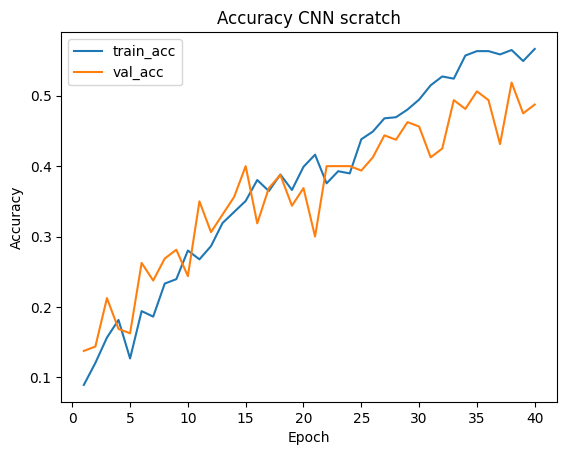

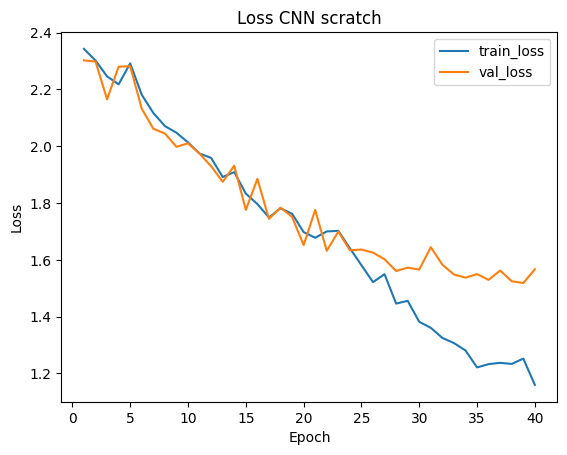

In [65]:
import matplotlib.pyplot as plt

def plot_history(history, title=""):
    acc = history.history.get("accuracy", [])
    val_acc = history.history.get("val_accuracy", [])
    loss = history.history.get("loss", [])
    val_loss = history.history.get("val_loss", [])

    epochs_range = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs_range, acc, label="train_acc")
    plt.plot(epochs_range, val_acc, label="val_acc")
    plt.title(f"Accuracy {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs_range, loss, label="train_loss")
    plt.plot(epochs_range, val_loss, label="val_loss")
    plt.title(f"Loss {title}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history_cnn, title="CNN scratch")

## ALL RESULTS

In [69]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix

results = []
reports_text = []

if "test_acc_cnn" in globals():
    results.append({
        "model": "CNN_scratch",
        "task": "Task1",
        "test_accuracy": float(test_acc_cnn),
        "test_loss": float(test_loss_cnn),
        "emissions_kg": float(emissions_cnn) if "emissions_cnn" in globals() else np.nan,
        "elapsed_seconds": float(elapsed_cnn) if "elapsed_cnn" in globals() else np.nan,
    })
    reports_text.append("=== CNN SCRATCH (TASK 1) ===\n")
    reports_text.append(f"Test accuracy: {test_acc_cnn}\n")
    reports_text.append(f"Test loss: {test_loss_cnn}\n")
    if "emissions_cnn" in globals():
        reports_text.append(f"CO2 emissions (kg): {emissions_cnn}\n")
    if "elapsed_cnn" in globals():
        reports_text.append(f"Elapsed time (s): {elapsed_cnn}\n")
    reports_text.append("\nClassification report (CNN scratch):\n")
    reports_text.append(classification_report(y_true_cnn, y_pred_cnn))
    reports_text.append("\nConfusion matrix (CNN scratch):\n")
    reports_text.append(np.array2string(confusion_matrix(y_true_cnn, y_pred_cnn)))
    reports_text.append("\n\n")

if "test_acc_vgg" in globals():
    results.append({
        "model": "VGG16_finetuned",
        "task": "Task2",
        "test_accuracy": float(test_acc_vgg),
        "test_loss": float(test_loss_vgg),
        "emissions_kg_head": float(emissions_vgg_head) if "emissions_vgg_head" in globals() else np.nan,
        "elapsed_seconds_head": float(elapsed_vgg_head) if "elapsed_vgg_head" in globals() else np.nan,
        "emissions_kg_ft": float(emissions_vgg_ft) if "emissions_vgg_ft" in globals() else np.nan,
        "elapsed_seconds_ft": float(elapsed_vgg_ft) if "elapsed_vgg_ft" in globals() else np.nan,
    })
    reports_text.append("=== VGG16 FINE-TUNED (TASK 2) ===\n")
    reports_text.append(f"Test accuracy: {test_acc_vgg}\n")
    reports_text.append(f"Test loss: {test_loss_vgg}\n")
    if "emissions_vgg_head" in globals():
        reports_text.append(f"CO2 emissions head (kg): {emissions_vgg_head}\n")
    if "elapsed_vgg_head" in globals():
        reports_text.append(f"Elapsed time head (s): {elapsed_vgg_head}\n")
    if "emissions_vgg_ft" in globals():
        reports_text.append(f"CO2 emissions fine-tune (kg): {emissions_vgg_ft}\n")
    if "elapsed_vgg_ft" in globals():
        reports_text.append(f"Elapsed time fine-tune (s): {elapsed_vgg_ft}\n")
    reports_text.append("\nClassification report (VGG16 fine-tuned):\n")
    reports_text.append(classification_report(y_true_vgg, y_pred_vgg))
    reports_text.append("\nConfusion matrix (VGG16 fine-tuned):\n")
    reports_text.append(np.array2string(confusion_matrix(y_true_vgg, y_pred_vgg)))
    reports_text.append("\n\n")

if "f30" in globals():
    reports_text.append("=== FEATURES CSV SHAPES ===\n")
    reports_text.append(f"lab2_features_30_sec shape: {f30.shape}\n")
if "f3" in globals():
    reports_text.append(f"lab2_features_3_sec shape: {f3.shape}\n")
    reports_text.append("\n")

summary_df = pd.DataFrame(results)
summary_path = "lab2_results_summary.csv"
summary_df.to_csv(summary_path, index=False)

details_text = "".join(reports_text)
details_path = "lab2_detailed_reports.txt"
with open(details_path, "w") as f:
    f.write(details_text)

print("=== SUMMARY DATAFRAME ===")
print(summary_df)
print("\n=== DETAILED REPORTS (PREVIEW) ===")
print(details_text)
print("\nFiles saved:")
print("Summary CSV:", summary_path)
print("Detailed TXT:", details_path)

=== SUMMARY DATAFRAME ===
             model   task  test_accuracy  test_loss  emissions_kg  \
0      CNN_scratch  Task1           0.55   1.411174      0.000153   
1  VGG16_finetuned  Task2           0.67   1.069173           NaN   

   elapsed_seconds  emissions_kg_head  elapsed_seconds_head  emissions_kg_ft  \
0       287.566005                NaN                   NaN              NaN   
1              NaN           0.000248            467.773202         0.000141   

   elapsed_seconds_ft  
0                 NaN  
1          264.843013  

=== DETAILED REPORTS (PREVIEW) ===
=== CNN SCRATCH (TASK 1) ===
Test accuracy: 0.550000011920929
Test loss: 1.4111741781234741
CO2 emissions (kg): 0.00015285272201852164
Elapsed time (s): 287.5660049915314

Classification report (CNN scratch):
              precision    recall  f1-score   support

           0       0.61      0.55      0.58        20
           1       0.73      0.80      0.76        20
           2       0.46      0.30      0.36  